##PIPELINE AVANCE

✅ 1_wIXlvBeAFtNVgJd49VObgQ.png: 117 grains détectés


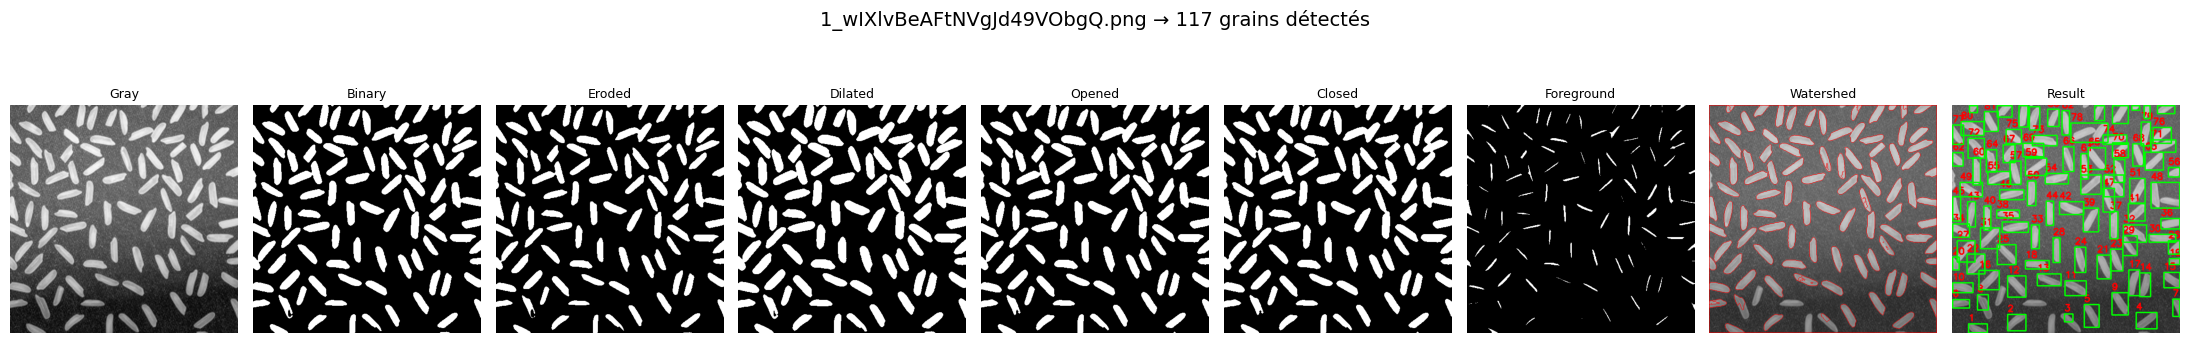

✅ 1_wIXlvBeAFtNVgJd49VObgQ.png_Salt_Pepper_Noise1.png: 117 grains détectés


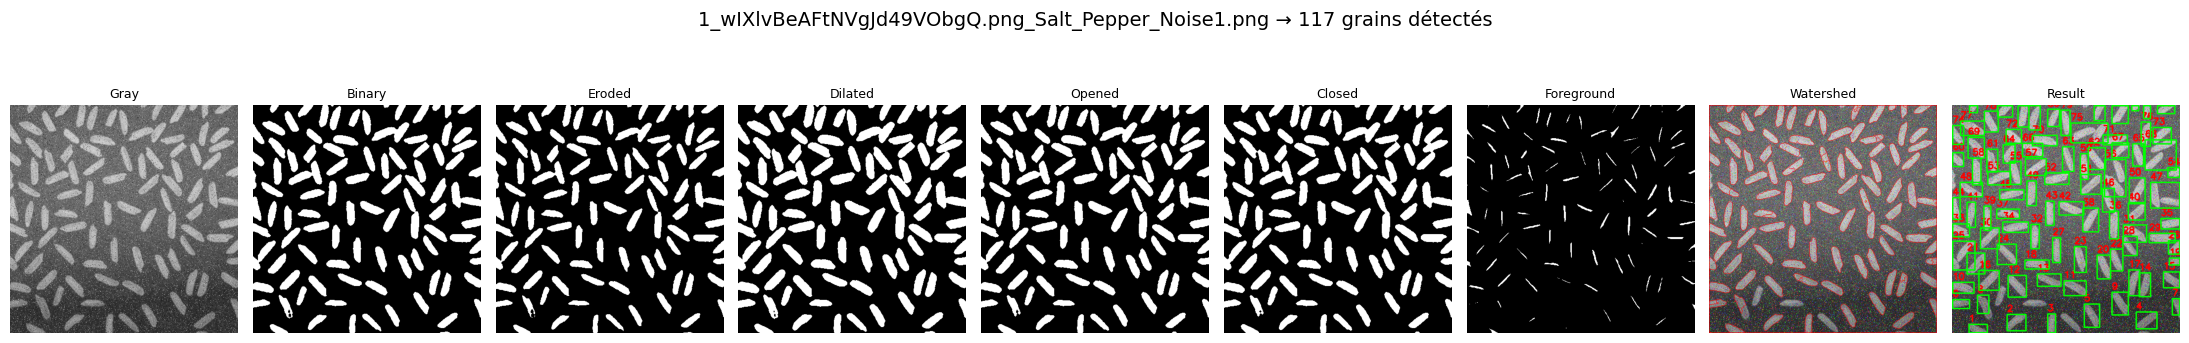

✅ 1_wIXlvBeAFtNVgJd49VObgQ_sinus.png: 66 grains détectés


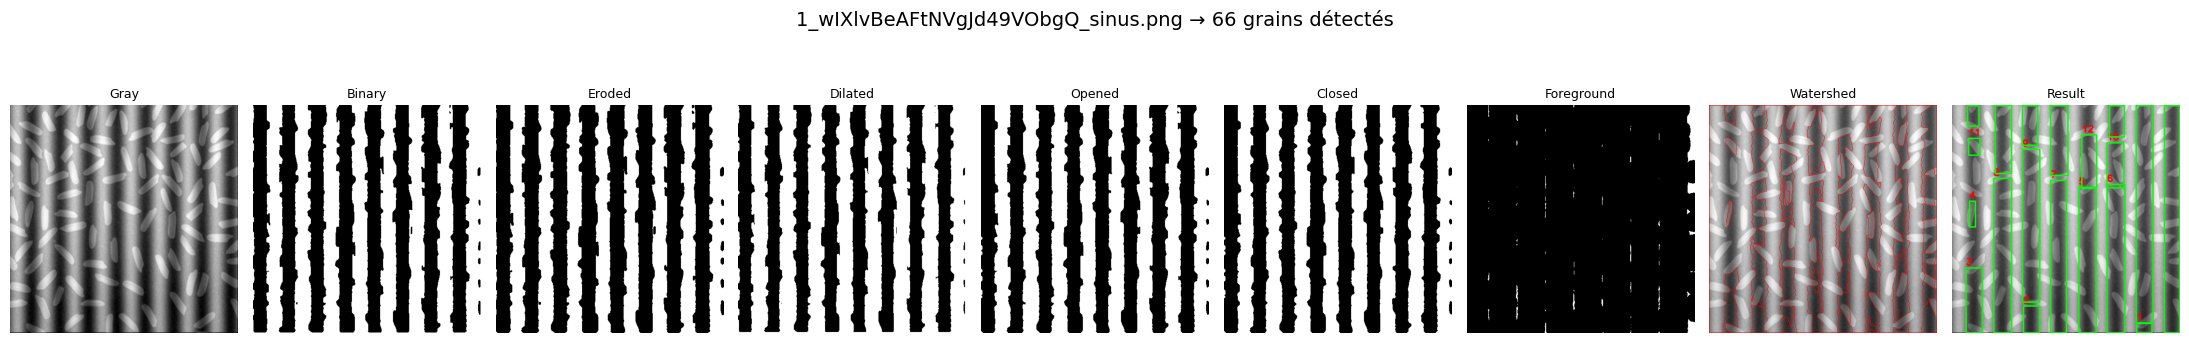

✅ 1_zd6ypc20QAIFMzrbCmJRMg.png: 88 grains détectés


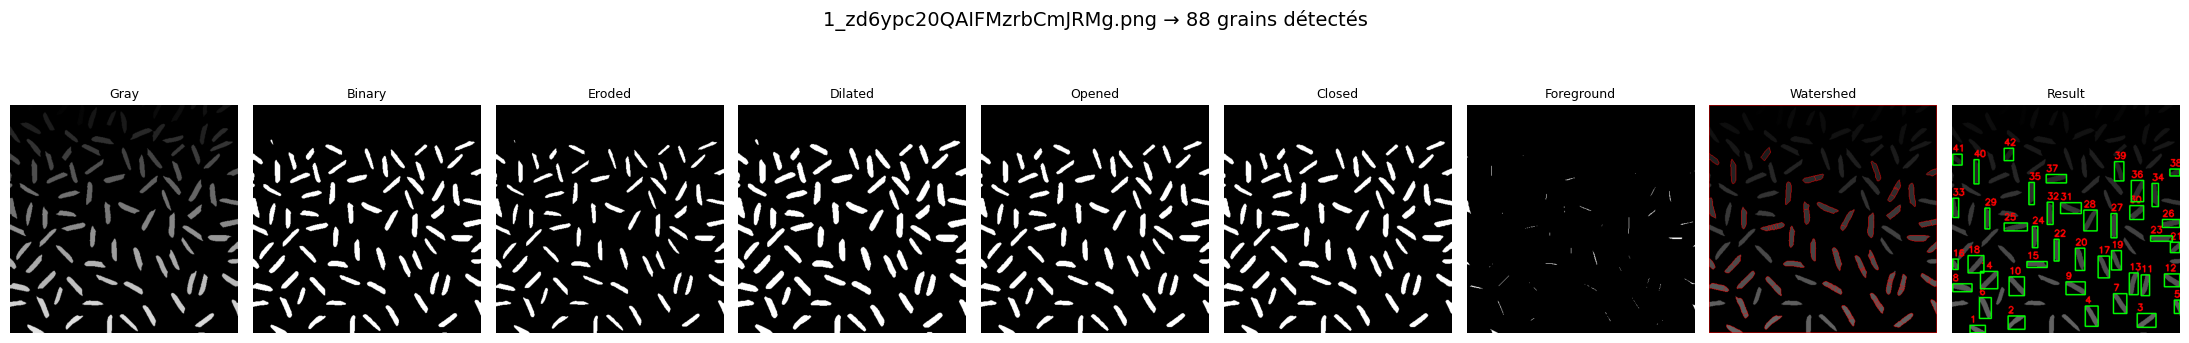


📂 Rapport sauvegardé dans D:\cours IFI\Traitement D'image\Images\Proj1.2\results_counts.csv


In [1]:
import cv2
import numpy as np
from PIL import Image
import os
import csv
import matplotlib.pyplot as plt
import pandas as pd

# ======================= Paramètres =======================
MEDIAN_K = 5
CLAHE_CLIP = 2.0
CLAHE_GRID = (8, 8)
KERNEL_SIZE = (3, 3)
OPEN_ITER = 2
CLOSE_ITER = 2
DIST_THRESH_FACTOR = 0.5
MIN_AREA = 30

# ======================= Pipeline amélioré =======================
def pipeline_grains(image_pil, real_count=None):
    img = np.array(image_pil)
    if img.ndim == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    # ---- Prétraitement ----
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    blurred = cv2.medianBlur(gray, MEDIAN_K)

    clahe = cv2.createCLAHE(clipLimit=CLAHE_CLIP, tileGridSize=CLAHE_GRID)
    enhanced = clahe.apply(blurred)

    # ---- Segmentation ----
    _, binary = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    if np.mean(binary) > 127:  # inversion si nécessaire
        binary = cv2.bitwise_not(binary)

    # ---- Morphologie ----
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, KERNEL_SIZE)
    eroded = cv2.erode(binary, kernel, iterations=1)
    dilated = cv2.dilate(binary, kernel, iterations=1)
    opened = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=OPEN_ITER)
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel, iterations=CLOSE_ITER)

    # ---- Distance Transform + Watershed ----
    dist = cv2.distanceTransform(closed, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist, DIST_THRESH_FACTOR * dist.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)

    sure_bg = cv2.dilate(closed, kernel, iterations=3)
    unknown = cv2.subtract(sure_bg, sure_fg)

    num_markers, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0

    markers = cv2.watershed(img_bgr, markers)

    # ---- Résultat final (après Watershed) ----
    wshed_result = img_bgr.copy()
    wshed_result[markers == -1] = [0, 0, 255]

    # Compter le nombre d'objets (labels > 1)
    unique_labels = np.unique(markers)
    grain_labels = [lab for lab in unique_labels if lab > 1]
    count = len(grain_labels)

    # ---- Visualisation ----
    vis = img_bgr.copy()
    contours, _ = cv2.findContours(np.uint8(markers > 1), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    obj_idx = 0
    for c in contours:
        area = cv2.contourArea(c)
        if area < MIN_AREA:
            continue
        obj_idx += 1
        x, y, w, h = cv2.boundingRect(c)
        cv2.rectangle(vis, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(vis, str(obj_idx), (x, y - 6), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

    # ---- Erreur si "ground truth" connue ----
    error = None
    if real_count is not None:
        error = count - real_count

    return {
        "gray": gray,
        "binary": binary,
        "eroded": eroded,
        "dilated": dilated,
        "opened": opened,
        "closed": closed,
        "foreground": sure_fg,
        "watershed": wshed_result,
        "result": vis,
        "count": count,
        "real_count": real_count,
        "error": error
    }

# ======================= Traitement dossier complet =======================
def traiter_plusieurs_horizontal(folder_path):
    # Charger vérité terrain si dispo
    gt_path = os.path.join(folder_path, "ground_truth.csv")
    ground_truth = {}
    if os.path.exists(gt_path):
        df_gt = pd.read_csv(gt_path)
        ground_truth = dict(zip(df_gt["filename"], df_gt["real_count"]))

    report_lines = []

    for f in os.listdir(folder_path):
        if f.lower().endswith((".jpg", ".png", ".jpeg", ".bmp")):
            img_path = os.path.join(folder_path, f)
            try:
                img = Image.open(img_path).convert("RGB")
            except Exception as e:
                print(f"❌ Impossible d'ouvrir {f}: {e}")
                continue

            real_count = ground_truth.get(f, None)
            out = pipeline_grains(img, real_count=real_count)

            # Sauvegarde résultat
            report_lines.append([f, out["count"], out["real_count"], out["error"]])

            # Affichage console
            print(f"✅ {f}: {out['count']} grains détectés", end="")
            if out["real_count"] is not None:
                print(f" (vérité terrain={out['real_count']}, erreur={out['error']})")
            else:
                print()

            # Affichage graphique (inclut Érosion et Dilatation maintenant)
            titles = ["Gray", "Binary", "Eroded", "Dilated", "Opened", "Closed", "Foreground", "Watershed", "Result"]
            images = [out["gray"], out["binary"], out["eroded"], out["dilated"],
                      out["opened"], out["closed"], out["foreground"], out["watershed"], out["result"]]

            plt.figure(figsize=(22, 4))
            for i, (im, title) in enumerate(zip(images, titles)):
                plt.subplot(1, len(images), i + 1)
                if len(im.shape) == 2:
                    plt.imshow(im, cmap="gray")
                else:
                    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
                plt.title(title, fontsize=9)
                plt.axis("off")
            plt.suptitle(f"{f} → {out['count']} grains détectés", fontsize=14)
            plt.tight_layout()
            plt.show()

    # Sauvegarde CSV résultats
    out_csv = os.path.join(folder_path, "results_counts.csv")
    with open(out_csv, "w", newline="", encoding="utf8") as csvf:
        writer = csv.writer(csvf)
        writer.writerow(["filename", "detected_count", "real_count", "error"])
        writer.writerows(report_lines)
    print(f"\n📂 Rapport sauvegardé dans {out_csv}")

# ======================= Exemple =======================
folder_path = r"D:\cours IFI\Traitement D'image\Images\Proj1.2"
traiter_plusieurs_horizontal(folder_path)


##PIPELINE DIRECT

✅ 1_wIXlvBeAFtNVgJd49VObgQ.png : 96 grains de riz détectés


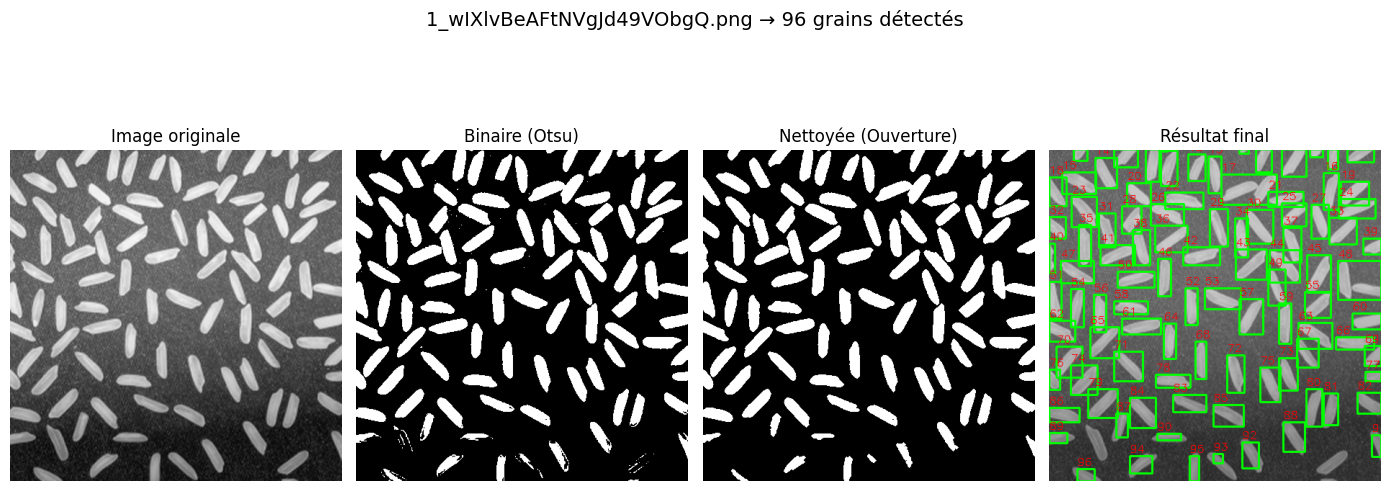

✅ 1_wIXlvBeAFtNVgJd49VObgQ.png_Salt_Pepper_Noise1.png : 110 grains de riz détectés


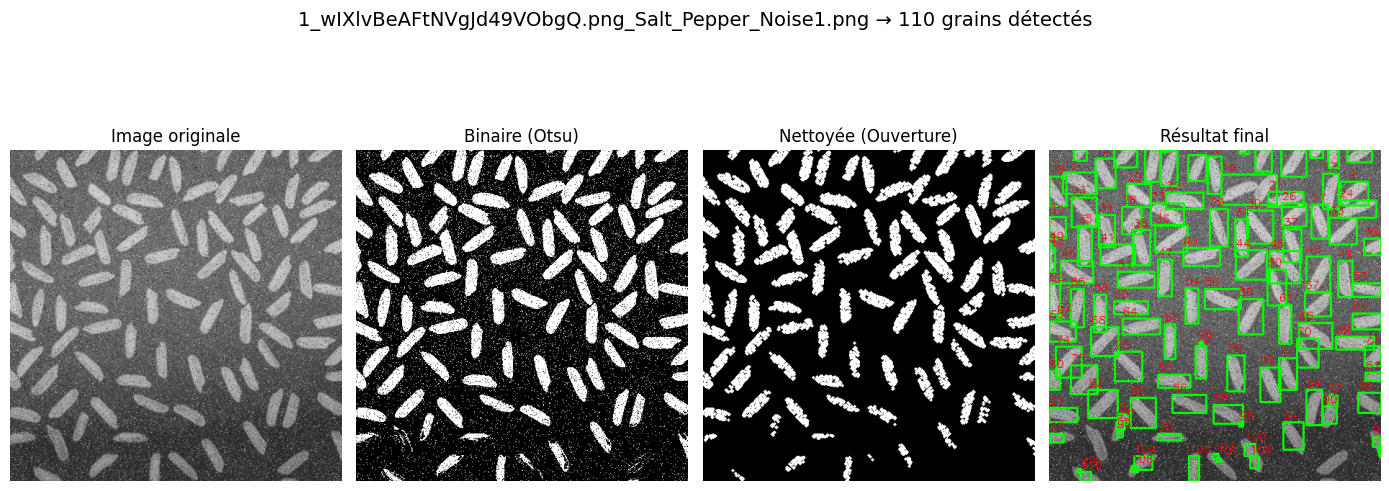

✅ 1_wIXlvBeAFtNVgJd49VObgQ_sinus.png : 13 grains de riz détectés


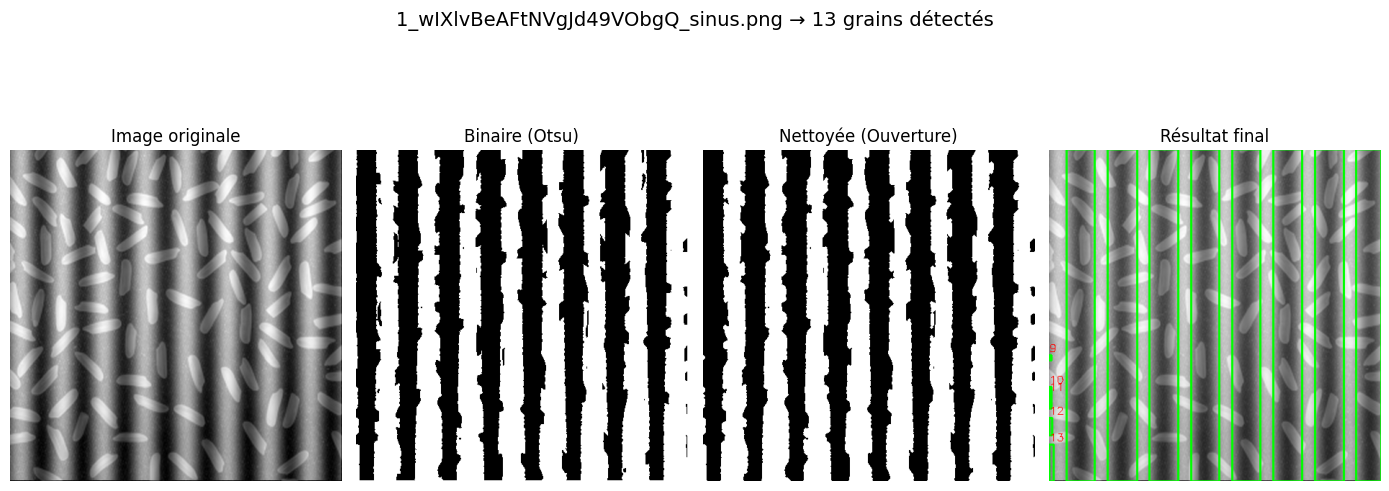

✅ 1_zd6ypc20QAIFMzrbCmJRMg.png : 67 grains de riz détectés


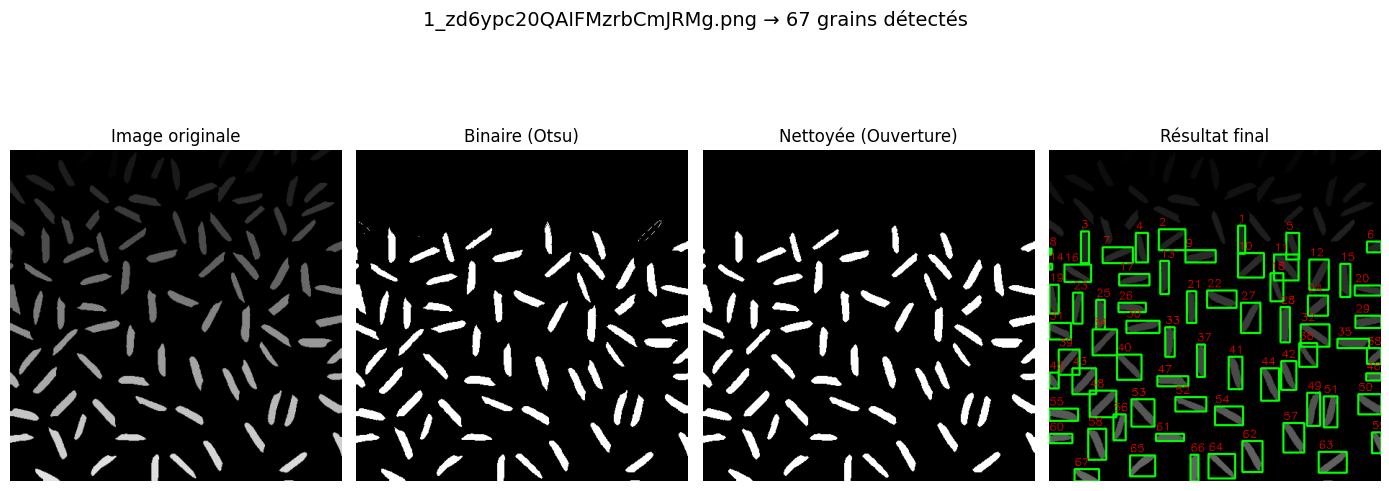

In [2]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# Chemin du dossier contenant les images
folder_path = r"D:\cours IFI\Traitement D'image\Images\Proj1.2"

# Lister toutes les images du dossier
for filename in os.listdir(folder_path):
    if filename.lower().endswith((".png", ".jpg", ".jpeg", ".bmp")):
        img_path = os.path.join(folder_path, filename)

        # Charger l'image en niveaux de gris
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"❌ Impossible de lire {filename}")
            continue

        # --- Seuillage Otsu ---
        _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Inversion si nécessaire
        if np.mean(binary) > 127:
            binary = cv2.bitwise_not(binary)

        # --- Morphologie (ouverture) ---
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        opened = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)

        # --- Composantes connexes ---
        num_labels, labels = cv2.connectedComponents(opened)

        # --- Résultat final ---
        output = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        for label in range(1, num_labels):  # 0 = fond
            mask = np.uint8(labels == label) * 255
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            for c in contours:
                x, y, w, h = cv2.boundingRect(c)
                cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 2)
                cv2.putText(output, str(label), (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 
                            0.5, (0, 0, 255), 1)

        # --- Résultats ---
        print(f"✅ {filename} : {num_labels - 1} grains de riz détectés")

        # --- Affichage avec Matplotlib ---
        titles = ["Image originale", "Binaire (Otsu)", "Nettoyée (Ouverture)", "Résultat final"]
        images = [img, binary, opened, output]

        plt.figure(figsize=(14, 6))
        for i, (im, title) in enumerate(zip(images, titles)):
            plt.subplot(1, 4, i + 1)
            if len(im.shape) == 2:  # image en niveaux de gris
                plt.imshow(im, cmap="gray")
            else:  # image couleur BGR → RGB
                plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
            plt.title(title)
            plt.axis("off")
        plt.suptitle(f"{filename} → {num_labels - 1} grains détectés", fontsize=14)
        plt.tight_layout()
        plt.show()
